In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb
import os, sys
import glob
import numpy as np
import torch
import pandas as pd
import random
import torch.nn as nn
import pickle
import torch.nn.functional as F

In [3]:
from mstcn_model import *
from utility.adaptive_data_loader import Breakfast, collate_fn_override
from utils import calculate_mof, dotdict

In [4]:
os.environ["WANDB_API_KEY"] = "992b3b1371ba79f48484cfca522b3786d7fa52c2"
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dipika_singhania (use `wandb login --relogin` to force relogin)


True

In [5]:
seed = 42

# Ensure deterministic behavior
def set_seed():
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
set_seed()

# Device configuration
os.environ['CUDA_VISIBLE_DEVICES'] = '4'
# os.environ['CUDA_LAUNCH_BLOCKING']='6'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
config = dotdict(
    epochs=500,
    num_class=48,
    batch_size=8,
    learning_rate=5e-4,
    weight_decay=0,
    dataset="Breakfast",
    architecture="unet-ensemble",
    features_file_name="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/",
    chunk_size=1,
    max_frames_per_video=1200,
    feature_size=2048,
    ground_truth_files_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/",
    label_id_csv="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv",
    gamma=0.1,
    step_size=500,
    split=1,
#     output_dir="/mnt/data/ar-datasets/dipika/breakfast/ms_tcn/data/breakfast/results/unsuper-finetune-split2-0.05-data-llr/",
    output_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-lenassum-mstcn-split1-slup15/",
    project_name="breakfast-split-1",
    train_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split{}.bundle",
    test_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split{}.bundle",
    all_files="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt",
    cutoff=8,
    data_per = 0.2,
    budget=40,
    semi_supervised_split="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/semi_supervised/train.split{}_amt{}.bundle")

config.train_split_file = config.train_split_file.format(config.split)
config.semi_supervised_split = config.semi_supervised_split.format(config.split, config.data_per)
config.test_split_file = config.test_split_file.format(config.split)

if not os.path.exists(config.output_dir):
    os.mkdir(config.output_dir)

print(config)

{'epochs': 500, 'num_class': 48, 'batch_size': 8, 'learning_rate': 0.0005, 'weight_decay': 0, 'dataset': 'Breakfast', 'architecture': 'unet-ensemble', 'features_file_name': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/', 'chunk_size': 1, 'max_frames_per_video': 1200, 'feature_size': 2048, 'ground_truth_files_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/', 'label_id_csv': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv', 'gamma': 0.1, 'step_size': 500, 'split': 1, 'output_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-lenassum-mstcn-split1-slup15/', 'project_name': 'breakfast-split-1', 'train_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split1.bundle', 'test_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split1.bundle', 'all_files': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt', 'cutoff': 8, 'data_per': 0.2, 'budget': 40, 'semi_supervised_

In [7]:
traindataset = Breakfast(config, fold='train', fold_file_name=config.train_split_file)
testdataset = Breakfast(config, fold='test', fold_file_name=config.test_split_file)

Number of videos logged in train fold is 1460
Number of videos not found in train fold is 0
Number of videos logged in test fold is 252
Number of videos not found in test fold is 0


In [8]:
def _init_fn(worker_id):
    np.random.seed(int(seed))
trainloader = torch.utils.data.DataLoader(dataset=traindataset,
                                          batch_size=config.batch_size, 
                                          shuffle=True,
                                          pin_memory=True, num_workers=4, 
                                          collate_fn=lambda x: collate_fn_override(x, config.max_frames_per_video),
                                          worker_init_fn=_init_fn)
testloader = torch.utils.data.DataLoader(dataset=testdataset,
                                          batch_size=config.batch_size, 
                                          shuffle=False,
                                          pin_memory=True, num_workers=4,
                                          collate_fn=lambda x: collate_fn_override(x, config.max_frames_per_video),
                                          worker_init_fn=_init_fn)

In [9]:
df=pd.read_csv(config.label_id_csv)
label_id_to_label_name = {}
label_name_to_label_id_dict = {}
for i, ele in df.iterrows():
    label_id_to_label_name[ele.label_id] = ele.label_name
    label_name_to_label_id_dict[ele.label_name] = ele.label_id

In [10]:
# item = iter(trainloader).next()
# print(item[0]) # -- data feature
# print(item[1]) # -- valid count
# item[2] # -- Actual labels
# print(item[5]) # video names
# video_id_boundary_frames

In [11]:
# selected_frames_dict = pickle.load(open("data/breakfast_len_assum_annotations.pkl", 'rb'))
# loaded_vidid_selected_frames
boundary_frames_dict = pickle.load(open("data/breakfast_boundary_annotations.pkl", "rb"))
# video_id_boundary_frames

In [12]:
loaded_mean_var_actions = pickle.load(open("data/breakfast_meanvar_actions.pkl", "rb"))
def get_possion_prob(cur_len, cur_class):
    mean_class, std_class = loaded_mean_var_actions[label_id_to_label_name[cur_class]]
    mean_class = mean_class
    prob = cur_len * torch.log(torch.tensor(mean_class, device=device) + 1e-5)
    prob = prob - mean_class
    factorials = torch.cumsum(torch.log(torch.arange(1, torch.max(cur_len)+1, 1).type(torch.float).to(device)), 
                              dim=0)[min(cur_len)-1:]
    prob = prob - factorials
    return prob

# get_possion_prob(torch.arange(10, 21), 20)

In [13]:
prob_video_each_segment_dict = {}

In [14]:
def prob_vals_per_segment(selected_frames, cur_vid_feat, labels):
    prob_each_segment = []
    
    log_probs = torch.log(cur_vid_feat + 1e-8)
    cumsum_feat = torch.cumsum(log_probs, dim=0)
    cur_boundary = 0
    for i, cur_ele in enumerate(selected_frames[:-1]):

        next_ele = selected_frames[i + 1]
        label_cur_ele = labels[i]
        label_next_ele = labels[i + 1]

        indices = torch.arange(cur_ele, next_ele).to(cumsum_feat.device)
        strt_index = cumsum_feat[cur_ele - 1, :][None, :] if cur_ele > 0 else 0
        end_index = cumsum_feat[next_ele - 1, :][None, :]
        left_sum = (cumsum_feat[indices, :] - strt_index)[:,label_cur_ele]
        right_sum = (end_index - cumsum_feat[indices, :])[:,label_next_ele]

        cur_boundary_len = indices - cur_boundary
        len_prob = get_possion_prob(cur_boundary_len, label_cur_ele)

        prob = torch.softmax((left_sum + right_sum + len_prob), dim=0)
#         prob = torch.softmax((left_sum + right_sum), dim=0)

        cur_boundary = round(np.sum(np.arange(cur_ele, next_ele, 1) * prob.detach().cpu().numpy()).item())
        prob_each_segment.append(prob)
    
    return prob_each_segment

In [15]:
def calculate_element_probb(data_feat, data_count, video_ids): #, loaded_vidid_selected_frames, boundaries_dict):
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        
        selected_frames_indices_and_labels = selected_frames_dict[cur_vidid + ".txt"]
        selected_frames_indices = [ele[0] for ele in selected_frames_indices_and_labels]
        selected_frames_labels = [label_name_to_label_id_dict[ele[1]] for ele in selected_frames_indices_and_labels]
        prob_video = prob_vals_per_segment(selected_frames_indices, cur_vid_feat, selected_frames_labels)
        prob_video_each_segment_dict[cur_vidid] = prob_video

In [16]:
def get_estimated_loss(data_feat, data_count, video_ids): #, loaded_vidid_selected_frames, boundaries_dict):
#     global prob_video_each_segment_dict, loaded_vidid_selected_frames
    loss_arr = []
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        
        selected_frames_indices_and_labels = selected_frames_dict[cur_vidid + ".txt"]
        selected_frames_indices = [ele[0] for ele in selected_frames_indices_and_labels]
        selected_frames_labels = [label_name_to_label_id_dict[ele[1]] for ele in selected_frames_indices_and_labels]

        prob_each_video = prob_video_each_segment_dict[cur_vidid]
        
        log_probs = torch.log(cur_vid_feat + 1e-8)
        cumsum_feat = torch.cumsum(log_probs, dim=0)
        
        
        current_vid_prob_arr = []
        # Start segment log probability
        start_ele_idx = selected_frames_indices[0]
        if start_ele_idx > 0:
            start_ele_label_idx = selected_frames_labels[0]
            first_segment_prob = (cumsum_feat[start_ele_idx - 1, :])[start_ele_label_idx]
            current_vid_prob_arr.append(first_segment_prob.unsqueeze(0))
        
        for i, cur_ele in enumerate(selected_frames_indices[:-1]):
            next_ele = selected_frames_indices[i + 1]
            label_cur_ele = selected_frames_labels[i]
            label_next_ele = selected_frames_labels[i + 1]

            indices = torch.arange(cur_ele, next_ele)
            strt_index = cumsum_feat[cur_ele - 1, :][None, :] if cur_ele > 0 else 0
            end_index = cumsum_feat[next_ele - 1, :][None, :]
            left_sum = (cumsum_feat[indices, :] - strt_index)[:,label_cur_ele]
            right_sum = (end_index - cumsum_feat[indices, :])[:,label_next_ele]
            current_vid_prob_arr.append((left_sum + right_sum)  * (prob_each_video[i]))
        
        # End segment log probability
        end_index = cur_vid_count.item() - 1
        last_ele_label_idx = selected_frames_labels[-1]
        last_segment_sum_prob = (cumsum_feat[end_index, :] - cumsum_feat[selected_frames_indices[-1] - 1, \
                                                                         :])[last_ele_label_idx]
        current_vid_prob_arr.append(last_segment_sum_prob.unsqueeze(0))
            
        loss_arr.append(torch.cat(current_vid_prob_arr))
    return -torch.mean(torch.cat(loss_arr)), loss_arr

In [17]:
train_split_file_list = set(open(config.train_split_file).read().split("\n")[0:-1])

def get_estimated_boundaries():
    estimated_boundary_dict = {}
    for video_id in train_split_file_list:
        ele = video_id.split(".txt")[0]
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        
        selected_frames_indices_and_labels = selected_frames_dict[video_id]
        selected_frames_indices = [ele[0] for ele in selected_frames_indices_and_labels]
        
        boundary_list = []
        for i, segment in enumerate(estimated_boundary_probs):
            estimated_boundary = np.sum(np.arange(selected_frames_indices[i], selected_frames_indices[i + 1], 1) \
                                        * segment.detach().cpu().numpy())
            estimated_boundary = round(estimated_boundary.item())
            
            if (estimated_boundary < selected_frames_indices[i]) or (estimated_boundary > selected_frames_indices[i + 1]):
                print("Estimated value wrong")
                import pdb
                pdb.set_trace()
            boundary_list.append(estimated_boundary)

        estimated_boundary_dict[ele] = boundary_list
    return estimated_boundary_dict

In [18]:
def get_boundary_err():
    err_list = []
    correct = 0.0
    total = 0.0
    estimated_boundar_dict = get_estimated_boundaries()
    for video_id in train_split_file_list:
        ele = video_id.split(".txt")[0]
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        estimated_boundary_list = estimated_boundar_dict[ele]
        
        estimated = np.array(estimated_boundary_list) #.detach().cpu().numpy()
        actual = np.array(boundary_frames_dict[video_id][:-1])
        if len(actual) != len(estimated):
            print(ele)
            continue
        
        mse_err = (actual - estimated)**2
        err_list.append(mse_err)
        
        estimated_labels = []
        actual_labels = []
        start_v1 = 0
        start_v2 = 0
        for i, v1 in enumerate(estimated):
            estimated_labels.extend([i] * (v1 - start_v1))
            start_v1 = v1
            v2 = actual[i]
            actual_labels.extend([i] * (v2 - start_v2))
            start_v2 = v2
            
        last_ele = boundary_frames_dict[video_id][-1]
        estimated_labels.extend([i+1] * (last_ele - start_v1))
        actual_labels.extend([i+1] * (last_ele - start_v2))
        
        correct += np.sum(np.array(actual_labels) == np.array(estimated_labels))
        total += len(actual_labels)
        
    print(f"Train Boundary avergage error = {np.sqrt(np.mean(np.concatenate(err_list))):.3f}")
    print(f"Train From boundary avergage accuracy = {correct * 100.0 / total:.3f}")

In [19]:
set_seed()
model = MultiStageModel(num_stages=4, num_layers=10, num_f_maps=64, dim=2048, num_classes=48).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# Requires loaded_vidid_selected_frames, boundaries_dict
ce_criterion = nn.CrossEntropyLoss(ignore_index=-100)
mse_criterion = nn.MSELoss(reduction='none')

In [20]:
# loaded_file=torch.load("/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/mstcn-lenpsuedo-full-supervised-split1/ms-tcn-best-model.wt")
# model.load_state_dict(loaded_file)

In [21]:
pseudo_labels_dir = "/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/length_segmentation_output/"
def get_single_random(output_p, video_ids):
    # Generate target for only timestamps. Do not generate pseudo labels at first 30 epochs.
    boundary_target_tensor = torch.ones((output_p.shape[0], output_p.shape[2]), dtype=torch.long, 
                                        device=output_p.device) * (-100)
    for iter_num, cur_vidid in enumerate(video_ids):
        pseudo_l = open(pseudo_labels_dir + cur_vidid + ".txt").read().split("\n")[0:-1]
        pseudo_l = [label_name_to_label_id_dict[ele] for ele in pseudo_l]
        abc = torch.tensor(pseudo_l).to(torch.long).to(boundary_target_tensor.device)
        frame_idx_tensor = torch.arange(0, len(pseudo_l), 1).to(device)
        boundary_target_tensor[iter_num, frame_idx_tensor] = abc

    return boundary_target_tensor

In [22]:
weakly_labels = pickle.load(open("data/breakfast_weaklysupervised_labels.pkl", "rb"))

In [23]:
prior_probs = pickle.load(open('data/breakfast_lengthmodel_multinomial_prior.pkl', 'rb'))

In [24]:
import copy
def change_selected_frames(model):
    global selected_frames_dict
    new_selected_frame_dict = {}
    with torch.no_grad():
        for train_idx, item in enumerate(trainloader):
            item_0 = item[0].to(device)
            item_1 = item[1].to(device)
            item_2 = item[2].to(device)
            src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
            src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)
            if train_idx % 10 == 0:
                print(f"Completed {train_idx} videos selected frames calculation")
            middle_pred, predictions = model(item_0, src_mask_mse)
            
            for idx, video_id in enumerate(item[4]):
                start = 0
                new_index_label_pair_list = []
                weakly_labels_video = [label_name_to_label_id_dict[wl] for wl in weakly_labels[video_id + ".txt"]]
                cur_video_predictions = predictions[-1][idx][:, :item_1[idx]]
                cur_preds_for_weakly_labels = torch.softmax(cur_video_predictions[weakly_labels_video], dim=0)
                prior_probs_cur_vid = prior_probs[video_id]
                weakly_labels_masked = []
                for i, prob_class in enumerate(cur_preds_for_weakly_labels):
                    prob_class_masked = prob_class * torch.tensor(prior_probs_cur_vid[i], 
                                                                  dtype=prob_class.dtype, device=prob_class.device)
                    weakly_labels_masked.append(prob_class_masked)
                    
                weakly_labels_masked = torch.stack(weakly_labels_masked)
                weakly_labels_masked = weakly_labels_masked / torch.sum(weakly_labels_masked, dim=0)

                for i in range(len(weakly_labels_video)):
                    cur_l = weakly_labels_video[i]
                    prob_class = weakly_labels_masked[i]
                    expected_value_of_class = torch.argmax(prob_class)
                    new_index_label_pair_list.append((int(expected_value_of_class.item()),
                                                      weakly_labels_video[i])) 
                
                back_list = copy.deepcopy(new_index_label_pair_list)
                error_list = []
                if new_index_label_pair_list[0][0] > new_index_label_pair_list[1][0]:
                    error_list.append(1)
                else:
                    error_list.append(0)
                    
                for i in range(1, len(new_index_label_pair_list) - 1, 1):
                    err = 0
                    prev_ele = new_index_label_pair_list[i - 1]
                    cur_ele = new_index_label_pair_list[i]
                    next_ele = new_index_label_pair_list[i + 1]
                    if not (prev_ele[0] < cur_ele[0]):
                        err += 1
                    if not (cur_ele[0] < next_ele[0]):
                        err += 1
                    error_list.append(err)

                if new_index_label_pair_list[-1][0] < new_index_label_pair_list[-2][0]:
                    error_list.append(1)
                else:
                    error_list.append(0)
                    
                if error_list[0] == 1 and error_list[1] == 1:
                    new_index = new_index_label_pair_list[1][0] // 2
                    new_index_label_pair_list[0] = (new_index, new_index_label_pair_list[0][1])
                    error_list[0] = 0
                    error_list[1] = 0
                    
                if error_list[-1] == 1 and error_list[-2] == 1:
                    new_index = (new_index_label_pair_list[-2][0] + weakly_labels_masked.shape[1]) // 2
                    new_index_label_pair_list[-1] = (new_index, new_index_label_pair_list[-1][1])
                    error_list[-1] = 0
                    error_list[-2] = 0
                    
                start_flag = False
                start_index = -1
                end_index = -1
                for i in range(1, len(error_list) - 1):
                    if error_list[i] == 1 and error_list[i + 1] == 2:
                        start_flag = True
                        start_index = i
                        
                    if (start_flag is True) and (error_list[i] == 2 or error_list[i + 1] == 1):
                        start_flag = False
                        end_index = i + 1
                        
                        num_div = end_index - start_index - 1
                        increm = (new_index_label_pair_list[end_index][0] - \
                                  new_index_label_pair_list[start_index][0]) // num_div
                        value = list(range(new_index_label_pair_list[start_index][0], 
                                           new_index_label_pair_list[end_index][0], increm))
                        count = 0
                        for ch_i in range(start_index + 1, end_index):
                            old_ele = new_index_label_pair_list[ch_i]
                            new_ele = (value[count], old_ele[1])
                            new_index_label_pair_list[ch_i] = new_ele
                            count += 1
                    
                final_list = new_index_label_pair_list
                is_valid_list = True
                for i in range(1, len(final_list) - 1, 1):
                    cur_ele = final_list[i]
                    
                    if not (final_list[i - 1][0] < cur_ele[0] and cur_ele[0] < final_list[i + 1][0]):
                        is_valid_list  = False

                if is_valid_list == False:
                    print(f"Could not find expected solution for video {video_id}")
                    print(final_list)
                    print(back_list)
                    print(error_list)
                    new_selected_frame_dict[video_id + ".txt"] = selected_frames_dict[video_id + ".txt"]
                else:
                
                    label_name_final_list = []
                    for ele in final_list:
                        label_name_final_list.append((ele[0], label_id_to_label_name[ele[1]]))
                    new_selected_frame_dict[video_id + ".txt"] = label_name_final_list
                
        return new_selected_frame_dict

In [25]:
def get_new_selected_frame_acc(selected_frame_dict):
    correct = 0.0
    total = 0.0

    for video_id in selected_frame_dict.keys():
        ground_labels = open(config.ground_truth_files_dir + video_id).read().split("\n")[0:-1]
        ground_labels = np.array(ground_labels)

        selected_frames_index = [ele[0] for ele in selected_frame_dict[video_id]]
        selected_frames_labels = np.array([ele[1] for ele in selected_frame_dict[video_id]])

        ground_selected_labels = ground_labels[selected_frames_index]

        correct += np.sum(ground_selected_labels == selected_frames_labels)
        total += len(ground_selected_labels)

    print("Total correct pivots labels selected = ", correct * 100.0 / total)


In [26]:
# selected_frames_dict = change_selected_frames(model)
# get_new_selected_frame_acc(selected_frames_dict)

In [27]:
# Initialize Expection Boundaries
# print("Calculating Expectation")
# correct = 0.0
# total = 0.0
# model.eval()
# for i, item in enumerate(trainloader):
#     with torch.no_grad():
#         item_0 = item[0].to(device)
#         item_1 = item[1].to(device)
#         item_2 = item[2].to(device)
#         src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
#         src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

#         middle_pred, predictions = model(item_0, src_mask_mse)
#         prob = torch.softmax(predictions[-1], dim=1)
#         prob = prob.permute(0, 2, 1)
#         calculate_element_probb(prob, item_1, item[4])

#         if i % 10 == 0:
#             print(f"Completed iter {i}")

# get_boundary_err()

In [28]:
config.output_dir

'/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-lenassum-mstcn-split1-slup15/'

In [29]:
initialize_epoch = 25
expectation_cal_gap = 5
best_val_acc = 0

for epoch in range(150):
    print("Starting Training")
    model.train()
    for i, item in enumerate(trainloader):
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)
        optimizer.zero_grad()
        
        middle_pred, predictions = model(item_0, src_mask_mse)
        psuedo_l = get_single_random(predictions[-1], item[4])
        
        loss = 0
        for p in predictions:
            if epoch <= initialize_epoch:
                loss += ce_criterion(p, psuedo_l)
                loss += 0.15 * torch.mean(torch.clamp(mse_criterion(F.log_softmax(p[:, :, 1:], dim=1), 
                                                                    F.log_softmax(p.detach()[:, :, :-1], dim=1)),
                                                      min=0, max=16) * src_mask_mse[:, :, 1:])
            else:
                prob = torch.softmax(p, dim=1)
                prob = prob.permute(0, 2, 1)
                es_loss, _ = get_estimated_loss(prob, item_1, item[4])
                loss += es_loss
            

        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            with torch.no_grad():
                pred = torch.argmax(predictions[-1], dim=1)
                correct = float(torch.sum((pred == item_2) * src_mask).item())
                total = float(torch.sum(src_mask).item())
                print(f"Training:: Epoch {epoch}, Iteration {i}, Current loss {loss.item()}" +
                      f" Accuracy {correct * 100.0 / total}")

    # Calculating Expectation Step
    model.eval()
    
    print("Calculating Validation Data Accuracy")
    correct = 0.0
    total = 0.0
    for i, item in enumerate(testloader):
        with torch.no_grad():
            item_0 = item[0].to(device)
            item_1 = item[1].to(device)
            item_2 = item[2].to(device)
            src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
            src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

            middle_pred, predictions = model(item_0, src_mask_mse)

            pred = torch.argmax(predictions[-1], dim=1)
            correct += float(torch.sum((pred == item_2) * src_mask).item())
            total += float(torch.sum(src_mask).item())

    val_acc = correct * 100.0 / total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), config.output_dir + "ms-tcn-emmax-best-model.wt")
    torch.save(model.state_dict(), config.output_dir + "ms-tcn-emmax-last-model.wt")
    print(f"Validation:: Epoch {epoch}, Probability Accuracy {val_acc}")

    if (epoch == initialize_epoch) or ((epoch > initialize_epoch) and ((epoch % (3 * expectation_cal_gap)) == 0)):
        torch.save(model.state_dict(), config.output_dir + f"ms-tcn-initial-{initialize_epoch}-epochs.wt")
        selected_frames_dict = change_selected_frames(model)
        get_new_selected_frame_acc(selected_frames_dict)

    if (epoch == initialize_epoch) or ((epoch > initialize_epoch) and (epoch % expectation_cal_gap == 0)):
        print("Calculating Expectation")
        correct = 0.0
        total = 0.0

        for i, item in enumerate(trainloader):
            with torch.no_grad():
                item_0 = item[0].to(device)
                item_1 = item[1].to(device)
                item_2 = item[2].to(device)
                src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
                src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

                middle_pred, predictions = model(item_0, src_mask_mse)
                prob = torch.softmax(predictions[-1], dim=1)
                prob = prob.permute(0, 2, 1)
                calculate_element_probb(prob, item_1, item[4])
                
                if i % 10 == 0:
                    print(f"Epoch {epoch} iter {i}")
                    
        get_boundary_err()



Starting Training
Training:: Epoch 0, Iteration 0, Current loss 15.761063575744629 Accuracy 3.641727949271214
Training:: Epoch 0, Iteration 10, Current loss 14.543675422668457 Accuracy 10.09473362534379
Training:: Epoch 0, Iteration 20, Current loss 14.211479187011719 Accuracy 7.272293752980448
Training:: Epoch 0, Iteration 30, Current loss 14.205370903015137 Accuracy 8.591975775927327
Training:: Epoch 0, Iteration 40, Current loss 13.268867492675781 Accuracy 7.281264466635805
Training:: Epoch 0, Iteration 50, Current loss 12.063504219055176 Accuracy 12.853293584819125
Training:: Epoch 0, Iteration 60, Current loss 11.476430892944336 Accuracy 17.390340342189866
Training:: Epoch 0, Iteration 70, Current loss 13.139060020446777 Accuracy 15.825115836996554
Training:: Epoch 0, Iteration 80, Current loss 10.582386016845703 Accuracy 20.540387607865327
Training:: Epoch 0, Iteration 90, Current loss 11.887202262878418 Accuracy 10.747760883149343
Training:: Epoch 0, Iteration 100, Current loss 

Training:: Epoch 4, Iteration 80, Current loss 6.008396625518799 Accuracy 40.79711079582097
Training:: Epoch 4, Iteration 90, Current loss 5.735780715942383 Accuracy 59.95974408741284
Training:: Epoch 4, Iteration 100, Current loss 7.198534965515137 Accuracy 49.98315023252679
Training:: Epoch 4, Iteration 110, Current loss 5.953262805938721 Accuracy 48.89082462253194
Training:: Epoch 4, Iteration 120, Current loss 5.1580071449279785 Accuracy 47.13030472985605
Training:: Epoch 4, Iteration 130, Current loss 6.838930606842041 Accuracy 37.08718064918144
Training:: Epoch 4, Iteration 140, Current loss 6.20133638381958 Accuracy 38.865189192938644
Training:: Epoch 4, Iteration 150, Current loss 6.425107479095459 Accuracy 43.06343989642466
Training:: Epoch 4, Iteration 160, Current loss 8.105634689331055 Accuracy 29.419256240448295
Training:: Epoch 4, Iteration 170, Current loss 5.667147159576416 Accuracy 39.253700229309985
Training:: Epoch 4, Iteration 180, Current loss 6.21804666519165 Accu

Training:: Epoch 8, Iteration 160, Current loss 6.972684860229492 Accuracy 42.918454935622314
Training:: Epoch 8, Iteration 170, Current loss 4.073175430297852 Accuracy 57.47234643445517
Training:: Epoch 8, Iteration 180, Current loss 4.178826808929443 Accuracy 62.42781242781243
Calculating Validation Data Accuracy
Validation:: Epoch 8, Probability Accuracy 52.49731907198341
Starting Training
Training:: Epoch 9, Iteration 0, Current loss 4.093345642089844 Accuracy 63.05899784482759
Training:: Epoch 9, Iteration 10, Current loss 4.398512363433838 Accuracy 46.017310587054695
Training:: Epoch 9, Iteration 20, Current loss 6.104284763336182 Accuracy 44.84669598216975
Training:: Epoch 9, Iteration 30, Current loss 5.327619552612305 Accuracy 50.62379494159011
Training:: Epoch 9, Iteration 40, Current loss 4.403750896453857 Accuracy 59.836029444175075
Training:: Epoch 9, Iteration 50, Current loss 4.243187427520752 Accuracy 51.52275849002984
Training:: Epoch 9, Iteration 60, Current loss 6.32

Training:: Epoch 13, Iteration 30, Current loss 4.7474822998046875 Accuracy 50.601334210279056
Training:: Epoch 13, Iteration 40, Current loss 4.587673187255859 Accuracy 59.638789202683725
Training:: Epoch 13, Iteration 50, Current loss 4.754223346710205 Accuracy 56.66896661536012
Training:: Epoch 13, Iteration 60, Current loss 5.033309459686279 Accuracy 59.74377668992813
Training:: Epoch 13, Iteration 70, Current loss 6.212155818939209 Accuracy 61.55022947475778
Training:: Epoch 13, Iteration 80, Current loss 3.698018789291382 Accuracy 59.987581496429684
Training:: Epoch 13, Iteration 90, Current loss 4.479087829589844 Accuracy 49.542048293089096
Training:: Epoch 13, Iteration 100, Current loss 3.343437671661377 Accuracy 55.682739972960796
Training:: Epoch 13, Iteration 110, Current loss 4.523863792419434 Accuracy 52.52379231417901
Training:: Epoch 13, Iteration 120, Current loss 4.510784149169922 Accuracy 53.45132743362832
Training:: Epoch 13, Iteration 130, Current loss 4.2219514846

Training:: Epoch 17, Iteration 100, Current loss 2.8797171115875244 Accuracy 61.37837837837838
Training:: Epoch 17, Iteration 110, Current loss 4.895187854766846 Accuracy 43.425685693106004
Training:: Epoch 17, Iteration 120, Current loss 4.8804521560668945 Accuracy 57.7720207253886
Training:: Epoch 17, Iteration 130, Current loss 3.918246269226074 Accuracy 56.966796290756804
Training:: Epoch 17, Iteration 140, Current loss 4.754707336425781 Accuracy 55.18890483022477
Training:: Epoch 17, Iteration 150, Current loss 4.968391418457031 Accuracy 40.69064748201439
Training:: Epoch 17, Iteration 160, Current loss 3.634014844894409 Accuracy 55.674661664210106
Training:: Epoch 17, Iteration 170, Current loss 3.405290365219116 Accuracy 61.87323770994238
Training:: Epoch 17, Iteration 180, Current loss 3.090705156326294 Accuracy 75.89579610646102
Calculating Validation Data Accuracy
Validation:: Epoch 17, Probability Accuracy 56.31511885117783
Starting Training
Training:: Epoch 18, Iteration 0,

Training:: Epoch 21, Iteration 170, Current loss 4.166781902313232 Accuracy 53.40278305832256
Training:: Epoch 21, Iteration 180, Current loss 3.330216407775879 Accuracy 65.11240212174792
Calculating Validation Data Accuracy
Validation:: Epoch 21, Probability Accuracy 56.56085409815956
Starting Training
Training:: Epoch 22, Iteration 0, Current loss 2.2356889247894287 Accuracy 60.93329022523979
Training:: Epoch 22, Iteration 10, Current loss 2.526156187057495 Accuracy 72.52747252747253
Training:: Epoch 22, Iteration 20, Current loss 3.048110008239746 Accuracy 60.25134649910233
Training:: Epoch 22, Iteration 30, Current loss 3.304725408554077 Accuracy 60.58989847063359
Training:: Epoch 22, Iteration 40, Current loss 2.9977450370788574 Accuracy 65.21101515398404
Training:: Epoch 22, Iteration 50, Current loss 2.8187077045440674 Accuracy 48.74983806192512
Training:: Epoch 22, Iteration 60, Current loss 2.9589359760284424 Accuracy 60.97927543110267
Training:: Epoch 22, Iteration 70, Curren

Completed 70 videos selected frames calculation
Completed 80 videos selected frames calculation
Completed 90 videos selected frames calculation
Completed 100 videos selected frames calculation
Completed 110 videos selected frames calculation
Completed 120 videos selected frames calculation
Completed 130 videos selected frames calculation
Completed 140 videos selected frames calculation
Completed 150 videos selected frames calculation
Completed 160 videos selected frames calculation
Completed 170 videos selected frames calculation
Completed 180 videos selected frames calculation
Total correct pivots labels selected =  61.18361153262519
Calculating Expectation
Epoch 25 iter 0
Epoch 25 iter 10
Epoch 25 iter 20
Epoch 25 iter 30
Epoch 25 iter 40
Epoch 25 iter 50
Epoch 25 iter 60
Epoch 25 iter 70
Epoch 25 iter 80
Epoch 25 iter 90
Epoch 25 iter 100
Epoch 25 iter 110
Epoch 25 iter 120
Epoch 25 iter 130
Epoch 25 iter 140
Epoch 25 iter 150
Epoch 25 iter 160
Epoch 25 iter 170
Epoch 25 iter 180
Tr

Training:: Epoch 29, Iteration 150, Current loss 2.3164326515242823 Accuracy 63.53785103785104
Training:: Epoch 29, Iteration 160, Current loss 1.412520962103732 Accuracy 56.59698292365419
Training:: Epoch 29, Iteration 170, Current loss 3.370622935677599 Accuracy 50.38850518006907
Training:: Epoch 29, Iteration 180, Current loss 2.3588398699571673 Accuracy 52.29637293786285
Calculating Validation Data Accuracy
Validation:: Epoch 29, Probability Accuracy 51.937786641657866
Starting Training
Training:: Epoch 30, Iteration 0, Current loss 2.9037573351038866 Accuracy 49.84511599091347
Training:: Epoch 30, Iteration 10, Current loss 1.607448407887253 Accuracy 71.26078958539692
Training:: Epoch 30, Iteration 20, Current loss 1.4629818100448433 Accuracy 67.00591463739543
Training:: Epoch 30, Iteration 30, Current loss 1.774445838102459 Accuracy 54.226383846104845
Training:: Epoch 30, Iteration 40, Current loss 1.4608229033586613 Accuracy 70.96125100609406
Training:: Epoch 30, Iteration 50, C

Training:: Epoch 33, Iteration 170, Current loss 1.1888998344104547 Accuracy 70.61017300321144
Training:: Epoch 33, Iteration 180, Current loss 1.3870120396515035 Accuracy 60.127505952838156
Calculating Validation Data Accuracy
Validation:: Epoch 33, Probability Accuracy 57.55665562638745
Starting Training
Training:: Epoch 34, Iteration 0, Current loss 1.2530569890105427 Accuracy 63.84261746969968
Training:: Epoch 34, Iteration 10, Current loss 0.8096014188396443 Accuracy 69.87420474262579
Training:: Epoch 34, Iteration 20, Current loss 1.285113801370442 Accuracy 63.58921976899505
Training:: Epoch 34, Iteration 30, Current loss 0.9297228411775617 Accuracy 75.1882602819077
Training:: Epoch 34, Iteration 40, Current loss 1.2576088774350629 Accuracy 59.370499897140505
Training:: Epoch 34, Iteration 50, Current loss 1.1631860565318834 Accuracy 73.39492851362287
Training:: Epoch 34, Iteration 60, Current loss 0.806217894817916 Accuracy 72.46366876885111
Training:: Epoch 34, Iteration 70, Cu

Calculating Validation Data Accuracy
Validation:: Epoch 37, Probability Accuracy 56.579056709047094
Starting Training
Training:: Epoch 38, Iteration 0, Current loss 0.589387362211237 Accuracy 75.37403767007214
Training:: Epoch 38, Iteration 10, Current loss 1.1318702554424407 Accuracy 55.205525606469
Training:: Epoch 38, Iteration 20, Current loss 0.7661411392512337 Accuracy 56.22042436269272
Training:: Epoch 38, Iteration 30, Current loss 1.018981950586215 Accuracy 63.870850276142505
Training:: Epoch 38, Iteration 40, Current loss 0.9156420709626674 Accuracy 64.56681665595315
Training:: Epoch 38, Iteration 50, Current loss 1.0731662965188788 Accuracy 67.14992408287212
Training:: Epoch 38, Iteration 60, Current loss 0.9492875594223977 Accuracy 67.35698175107648
Training:: Epoch 38, Iteration 70, Current loss 1.1415254958426384 Accuracy 67.56215086776683
Training:: Epoch 38, Iteration 80, Current loss 1.3009411011849175 Accuracy 62.1868978805395
Training:: Epoch 38, Iteration 90, Curren

Training:: Epoch 42, Iteration 10, Current loss 1.023484878111468 Accuracy 61.54692243389503
Training:: Epoch 42, Iteration 20, Current loss 0.7447567477313984 Accuracy 71.57356349396628
Training:: Epoch 42, Iteration 30, Current loss 0.7144491903772998 Accuracy 58.35665347872238
Training:: Epoch 42, Iteration 40, Current loss 0.9249719003657311 Accuracy 48.9546935149541
Training:: Epoch 42, Iteration 50, Current loss 0.8066167418629915 Accuracy 63.225806451612904
Training:: Epoch 42, Iteration 60, Current loss 0.828696003713752 Accuracy 75.04764644539537
Training:: Epoch 42, Iteration 70, Current loss 0.9133445627923586 Accuracy 61.740976645435246
Training:: Epoch 42, Iteration 80, Current loss 0.8164950376053932 Accuracy 76.95672798186897
Training:: Epoch 42, Iteration 90, Current loss 0.8132774525683033 Accuracy 66.96058091286307
Training:: Epoch 42, Iteration 100, Current loss 0.8492081682886125 Accuracy 59.41664571284888
Training:: Epoch 42, Iteration 110, Current loss 1.246947472

Completed 140 videos selected frames calculation
Completed 150 videos selected frames calculation
Completed 160 videos selected frames calculation
Completed 170 videos selected frames calculation
Completed 180 videos selected frames calculation
Total correct pivots labels selected =  60.77895801719777
Calculating Expectation
Epoch 45 iter 0
Epoch 45 iter 10
Epoch 45 iter 20
Epoch 45 iter 30
Epoch 45 iter 40
Epoch 45 iter 50
Epoch 45 iter 60
Epoch 45 iter 70
Epoch 45 iter 80
Epoch 45 iter 90
Epoch 45 iter 100
Epoch 45 iter 110
Epoch 45 iter 120
Epoch 45 iter 130
Epoch 45 iter 140
Epoch 45 iter 150
Epoch 45 iter 160
Epoch 45 iter 170
Epoch 45 iter 180
Train Boundary avergage error = 295.823
Train From boundary avergage accuracy = 60.804
Starting Training
Training:: Epoch 46, Iteration 0, Current loss 0.7921825834144529 Accuracy 71.53745794135824
Training:: Epoch 46, Iteration 10, Current loss 0.968022462107531 Accuracy 62.648388920293954
Training:: Epoch 46, Iteration 20, Current loss 0.

Calculating Validation Data Accuracy
Validation:: Epoch 49, Probability Accuracy 55.77616328533384
Starting Training
Training:: Epoch 50, Iteration 0, Current loss 0.6022743077798538 Accuracy 68.82917722362981
Training:: Epoch 50, Iteration 10, Current loss 0.8315825912053993 Accuracy 62.49023075973839
Training:: Epoch 50, Iteration 20, Current loss 0.6262790467261601 Accuracy 69.83314566485822
Training:: Epoch 50, Iteration 30, Current loss 0.5639554467762642 Accuracy 74.51209992193598
Training:: Epoch 50, Iteration 40, Current loss 0.5816930009987173 Accuracy 56.48475751402738
Training:: Epoch 50, Iteration 50, Current loss 0.6000553675779824 Accuracy 67.92379745052469
Training:: Epoch 50, Iteration 60, Current loss 0.6527944448183748 Accuracy 63.851407629518576
Training:: Epoch 50, Iteration 70, Current loss 0.5771148384670708 Accuracy 57.32605383443372
Training:: Epoch 50, Iteration 80, Current loss 0.5931846045707037 Accuracy 66.88135028593638
Training:: Epoch 50, Iteration 90, Cu

Training:: Epoch 54, Iteration 0, Current loss 0.6081746062316375 Accuracy 61.315630657815326
Training:: Epoch 54, Iteration 10, Current loss 0.592183932300754 Accuracy 72.75874004845967
Training:: Epoch 54, Iteration 20, Current loss 0.7279809307847799 Accuracy 57.214544893074965
Training:: Epoch 54, Iteration 30, Current loss 0.7469364771023421 Accuracy 59.96587715776796
Training:: Epoch 54, Iteration 40, Current loss 0.5508505470873223 Accuracy 67.08321499573985
Training:: Epoch 54, Iteration 50, Current loss 0.5608999523634932 Accuracy 58.96481102215602
Training:: Epoch 54, Iteration 60, Current loss 0.5925146524578605 Accuracy 69.3107932379714
Training:: Epoch 54, Iteration 70, Current loss 0.5823858997515338 Accuracy 50.16021808790473
Training:: Epoch 54, Iteration 80, Current loss 0.6455303022386856 Accuracy 68.5511579135246
Training:: Epoch 54, Iteration 90, Current loss 0.5897100822914657 Accuracy 62.42569288967807
Training:: Epoch 54, Iteration 100, Current loss 0.47541720747

Training:: Epoch 58, Iteration 10, Current loss 0.5313099926837291 Accuracy 52.335198248601316
Training:: Epoch 58, Iteration 20, Current loss 0.4002745807550939 Accuracy 62.54868184541642
Training:: Epoch 58, Iteration 30, Current loss 0.4738558654799829 Accuracy 67.05130481093556
Training:: Epoch 58, Iteration 40, Current loss 0.536083798105744 Accuracy 61.26996647604023
Training:: Epoch 58, Iteration 50, Current loss 0.6492008099517979 Accuracy 42.02297147091515
Training:: Epoch 58, Iteration 60, Current loss 0.4137479852110646 Accuracy 66.71841413900167
Training:: Epoch 58, Iteration 70, Current loss 0.4088337070325796 Accuracy 72.6299464705588
Training:: Epoch 58, Iteration 80, Current loss 0.4444010189363466 Accuracy 73.31348132106118
Training:: Epoch 58, Iteration 90, Current loss 0.4391534337730767 Accuracy 74.1438529144358
Training:: Epoch 58, Iteration 100, Current loss 0.4352030595589179 Accuracy 72.43609725685785
Training:: Epoch 58, Iteration 110, Current loss 0.5706604239

Training:: Epoch 61, Iteration 130, Current loss 1.6534373128596274 Accuracy 72.76595744680851
Training:: Epoch 61, Iteration 140, Current loss 2.2724162092270914 Accuracy 61.02977061981454
Training:: Epoch 61, Iteration 150, Current loss 1.3353150368840145 Accuracy 58.64817645774186
Training:: Epoch 61, Iteration 160, Current loss 1.4244456122488314 Accuracy 61.867676478994
Training:: Epoch 61, Iteration 170, Current loss 7.093429486890868 Accuracy 55.96126082771896
Training:: Epoch 61, Iteration 180, Current loss 1.8226431729262456 Accuracy 58.87875901483195
Calculating Validation Data Accuracy
Validation:: Epoch 61, Probability Accuracy 50.584659947529
Starting Training
Training:: Epoch 62, Iteration 0, Current loss 1.4160961745993983 Accuracy 63.55004158580538
Training:: Epoch 62, Iteration 10, Current loss 1.139499151853508 Accuracy 66.77704624254937
Training:: Epoch 62, Iteration 20, Current loss 0.8453893105925199 Accuracy 64.37147121811928
Training:: Epoch 62, Iteration 30, Cur

Validation:: Epoch 65, Probability Accuracy 54.703000660833915
Calculating Expectation
Epoch 65 iter 0
Epoch 65 iter 10
Epoch 65 iter 20
Epoch 65 iter 30
Epoch 65 iter 40
Epoch 65 iter 50
Epoch 65 iter 60
Epoch 65 iter 70
Epoch 65 iter 80
Epoch 65 iter 90
Epoch 65 iter 100
Epoch 65 iter 110
Epoch 65 iter 120
Epoch 65 iter 130
Epoch 65 iter 140
Epoch 65 iter 150
Epoch 65 iter 160
Epoch 65 iter 170
Epoch 65 iter 180
Train Boundary avergage error = 295.501
Train From boundary avergage accuracy = 60.586
Starting Training
Training:: Epoch 66, Iteration 0, Current loss 0.3844088887391946 Accuracy 58.25436996056736
Training:: Epoch 66, Iteration 10, Current loss 0.6902973220395825 Accuracy 60.756551141166526
Training:: Epoch 66, Iteration 20, Current loss 0.3954437715266877 Accuracy 58.36447254958321
Training:: Epoch 66, Iteration 30, Current loss 0.6129405886433776 Accuracy 67.36998269183219
Training:: Epoch 66, Iteration 40, Current loss 0.45126025458656166 Accuracy 65.46617699324725
Traini

Training:: Epoch 70, Iteration 10, Current loss 0.5363236673440889 Accuracy 68.0808418239519
Training:: Epoch 70, Iteration 20, Current loss 0.32687441775518417 Accuracy 61.71341316402797
Training:: Epoch 70, Iteration 30, Current loss 0.6213151943901971 Accuracy 59.16130021465808
Training:: Epoch 70, Iteration 40, Current loss 0.47946928668824584 Accuracy 58.02776051377667
Training:: Epoch 70, Iteration 50, Current loss 0.4202224973670608 Accuracy 64.15611814345992
Training:: Epoch 70, Iteration 60, Current loss 0.49429537426214554 Accuracy 56.19118994087768
Training:: Epoch 70, Iteration 70, Current loss 0.4304052671982119 Accuracy 56.52054669287379
Training:: Epoch 70, Iteration 80, Current loss 0.4252636786103881 Accuracy 66.15522729127561
Training:: Epoch 70, Iteration 90, Current loss 0.39449657163425617 Accuracy 62.27562080633137
Training:: Epoch 70, Iteration 100, Current loss 0.3464980857039458 Accuracy 62.5817909889699
Training:: Epoch 70, Iteration 110, Current loss 0.408639

Training:: Epoch 74, Iteration 20, Current loss 0.3555030711347598 Accuracy 62.95063145809414
Training:: Epoch 74, Iteration 30, Current loss 0.3241771835128216 Accuracy 68.88994195000592
Training:: Epoch 74, Iteration 40, Current loss 0.364281560075615 Accuracy 66.39507053012171
Training:: Epoch 74, Iteration 50, Current loss 0.369122121789575 Accuracy 67.21454039481694
Training:: Epoch 74, Iteration 60, Current loss 0.2893027196932198 Accuracy 67.27466466090009
Training:: Epoch 74, Iteration 70, Current loss 0.2995890710065645 Accuracy 69.17998610145935
Training:: Epoch 74, Iteration 80, Current loss 0.3507172916688569 Accuracy 71.92307692307692
Training:: Epoch 74, Iteration 90, Current loss 0.3541383800754125 Accuracy 67.28525980911984
Training:: Epoch 74, Iteration 100, Current loss 0.2932654574063572 Accuracy 66.08882962355113
Training:: Epoch 74, Iteration 110, Current loss 0.4250417659278628 Accuracy 61.04197901049475
Training:: Epoch 74, Iteration 120, Current loss 0.404670220

Training:: Epoch 77, Iteration 130, Current loss 0.767502278115789 Accuracy 58.84597643309431
Training:: Epoch 77, Iteration 140, Current loss 0.5295912884046854 Accuracy 66.28589394256969
Training:: Epoch 77, Iteration 150, Current loss 0.5590368534073803 Accuracy 66.28937199953164
Training:: Epoch 77, Iteration 160, Current loss 0.6208177733447992 Accuracy 62.91280148423006
Training:: Epoch 77, Iteration 170, Current loss 0.5010480402182355 Accuracy 58.53460972017673
Training:: Epoch 77, Iteration 180, Current loss 0.461822349753435 Accuracy 63.18483039170658
Calculating Validation Data Accuracy
Validation:: Epoch 77, Probability Accuracy 53.646457811492176
Starting Training
Training:: Epoch 78, Iteration 0, Current loss 0.6031622479958351 Accuracy 59.48441708349365
Training:: Epoch 78, Iteration 10, Current loss 0.42839027446476097 Accuracy 72.07947927372388
Training:: Epoch 78, Iteration 20, Current loss 0.4815420617263083 Accuracy 64.97434801197093
Training:: Epoch 78, Iteration 3

Training:: Epoch 81, Iteration 150, Current loss 1.4022798783024155 Accuracy 69.31506849315069
Training:: Epoch 81, Iteration 160, Current loss 2.819958101182345 Accuracy 62.5714640815312
Training:: Epoch 81, Iteration 170, Current loss 3.6623289407332287 Accuracy 49.74043221055173
Training:: Epoch 81, Iteration 180, Current loss 3.956571498672396 Accuracy 46.197773601272225
Calculating Validation Data Accuracy
Validation:: Epoch 81, Probability Accuracy 52.04680445251691
Starting Training
Training:: Epoch 82, Iteration 0, Current loss 4.03840642972752 Accuracy 58.71091257179324
Training:: Epoch 82, Iteration 10, Current loss 1.5489369660063268 Accuracy 59.01655795283492
Training:: Epoch 82, Iteration 20, Current loss 2.2235615414762746 Accuracy 59.0466141145801
Training:: Epoch 82, Iteration 30, Current loss 1.017401559902274 Accuracy 69.6137388689719
Training:: Epoch 82, Iteration 40, Current loss 2.568253285901274 Accuracy 47.68020322478213
Training:: Epoch 82, Iteration 50, Current

Epoch 85 iter 40
Epoch 85 iter 50
Epoch 85 iter 60
Epoch 85 iter 70
Epoch 85 iter 80
Epoch 85 iter 90
Epoch 85 iter 100
Epoch 85 iter 110
Epoch 85 iter 120
Epoch 85 iter 130
Epoch 85 iter 140
Epoch 85 iter 150
Epoch 85 iter 160
Epoch 85 iter 170
Epoch 85 iter 180
Train Boundary avergage error = 296.596
Train From boundary avergage accuracy = 60.365
Starting Training
Training:: Epoch 86, Iteration 0, Current loss 0.44936642699289137 Accuracy 51.48382794264755
Training:: Epoch 86, Iteration 10, Current loss 0.32913311935057915 Accuracy 61.213909714468016
Training:: Epoch 86, Iteration 20, Current loss 0.23780964347755182 Accuracy 60.49633489357944
Training:: Epoch 86, Iteration 30, Current loss 0.39653841956409275 Accuracy 58.47389558232932
Training:: Epoch 86, Iteration 40, Current loss 0.27632995359377177 Accuracy 58.871310507674146
Training:: Epoch 86, Iteration 50, Current loss 0.3229410703635734 Accuracy 65.8594935231649
Training:: Epoch 86, Iteration 60, Current loss 0.345260438143

Training:: Epoch 90, Iteration 20, Current loss 0.2811761780361644 Accuracy 60.61391269683077
Training:: Epoch 90, Iteration 30, Current loss 0.2898795554186297 Accuracy 60.555386642343166
Training:: Epoch 90, Iteration 40, Current loss 0.2503209955701911 Accuracy 68.58175248419151
Training:: Epoch 90, Iteration 50, Current loss 0.31428986596763464 Accuracy 63.25277723640616
Training:: Epoch 90, Iteration 60, Current loss 0.30329645173582276 Accuracy 61.99897225077081
Training:: Epoch 90, Iteration 70, Current loss 0.32451713154849904 Accuracy 63.085061659192824
Training:: Epoch 90, Iteration 80, Current loss 0.28952688563544055 Accuracy 66.05050505050505
Training:: Epoch 90, Iteration 90, Current loss 0.3594822937293678 Accuracy 69.64240554347276
Training:: Epoch 90, Iteration 100, Current loss 0.30756735303122795 Accuracy 65.0667629014796
Training:: Epoch 90, Iteration 110, Current loss 0.2412985645713832 Accuracy 60.26727372370473
Training:: Epoch 90, Iteration 120, Current loss 0.2

Training:: Epoch 93, Iteration 130, Current loss 0.3079466066884242 Accuracy 64.40976591995972
Training:: Epoch 93, Iteration 140, Current loss 0.3003507905027336 Accuracy 55.5939226519337
Training:: Epoch 93, Iteration 150, Current loss 0.2730615445864695 Accuracy 64.8136489549232
Training:: Epoch 93, Iteration 160, Current loss 0.3133982090218286 Accuracy 60.89691143383105
Training:: Epoch 93, Iteration 170, Current loss 0.22734622104650004 Accuracy 69.8882886182584
Training:: Epoch 93, Iteration 180, Current loss 0.26037640460266104 Accuracy 59.590179065903634
Calculating Validation Data Accuracy
Validation:: Epoch 93, Probability Accuracy 55.44515276343333
Starting Training
Training:: Epoch 94, Iteration 0, Current loss 0.2848736550017085 Accuracy 60.99176742989452
Training:: Epoch 94, Iteration 10, Current loss 0.2562234975778531 Accuracy 65.35779171306335
Training:: Epoch 94, Iteration 20, Current loss 0.2577133046171334 Accuracy 66.77774616978908
Training:: Epoch 94, Iteration 3

Training:: Epoch 97, Iteration 140, Current loss 0.9251958657232837 Accuracy 59.29358279419479
Training:: Epoch 97, Iteration 150, Current loss 1.0767948461798187 Accuracy 52.85322359396434
Training:: Epoch 97, Iteration 160, Current loss 1.079958151196685 Accuracy 60.650988411724605
Training:: Epoch 97, Iteration 170, Current loss 0.764794923226086 Accuracy 66.63518299881936
Training:: Epoch 97, Iteration 180, Current loss 0.8371544798995256 Accuracy 63.99674048509251
Calculating Validation Data Accuracy
Validation:: Epoch 97, Probability Accuracy 53.19139253930379
Starting Training
Training:: Epoch 98, Iteration 0, Current loss 0.5568841991773767 Accuracy 62.10702548521114
Training:: Epoch 98, Iteration 10, Current loss 0.6498193603944145 Accuracy 69.12959381044487
Training:: Epoch 98, Iteration 20, Current loss 0.4831289924650938 Accuracy 57.7183538808821
Training:: Epoch 98, Iteration 30, Current loss 0.4494698369645058 Accuracy 70.87888439356117
Training:: Epoch 98, Iteration 40, 

Training:: Epoch 101, Iteration 150, Current loss 0.2781475204912534 Accuracy 70.8041014570966
Training:: Epoch 101, Iteration 160, Current loss 0.24972961682665035 Accuracy 72.35081851786657
Training:: Epoch 101, Iteration 170, Current loss 0.29718879555188554 Accuracy 45.18056859899257
Training:: Epoch 101, Iteration 180, Current loss 0.3911122741025508 Accuracy 68.93004115226337
Calculating Validation Data Accuracy
Validation:: Epoch 101, Probability Accuracy 55.70493567751305
Starting Training
Training:: Epoch 102, Iteration 0, Current loss 0.2737266095534924 Accuracy 66.01478112563957
Training:: Epoch 102, Iteration 10, Current loss 0.27380380733272786 Accuracy 67.59826529909823
Training:: Epoch 102, Iteration 20, Current loss 0.2439088671754725 Accuracy 72.21009294491923
Training:: Epoch 102, Iteration 30, Current loss 0.23857804759726023 Accuracy 69.44609532865803
Training:: Epoch 102, Iteration 40, Current loss 0.20712978522261744 Accuracy 74.38217593580605
Training:: Epoch 102

Completed 0 videos selected frames calculation
Completed 10 videos selected frames calculation
Completed 20 videos selected frames calculation
Completed 30 videos selected frames calculation
Completed 40 videos selected frames calculation
Completed 50 videos selected frames calculation
Completed 60 videos selected frames calculation
Completed 70 videos selected frames calculation
Completed 80 videos selected frames calculation
Completed 90 videos selected frames calculation
Completed 100 videos selected frames calculation
Completed 110 videos selected frames calculation
Completed 120 videos selected frames calculation
Completed 130 videos selected frames calculation
Completed 140 videos selected frames calculation
Completed 150 videos selected frames calculation
Completed 160 videos selected frames calculation
Completed 170 videos selected frames calculation
Completed 180 videos selected frames calculation
Total correct pivots labels selected =  59.524532119372786
Calculating Expectati

Training:: Epoch 109, Iteration 100, Current loss 0.22773973548352708 Accuracy 68.65683051754453
Training:: Epoch 109, Iteration 110, Current loss 0.23931984533582418 Accuracy 59.34601664684899
Training:: Epoch 109, Iteration 120, Current loss 0.39740944816840296 Accuracy 51.94687305909894
Training:: Epoch 109, Iteration 130, Current loss 0.2482832069739183 Accuracy 65.72785561624318
Training:: Epoch 109, Iteration 140, Current loss 0.2507453259712667 Accuracy 62.9230070406541
Training:: Epoch 109, Iteration 150, Current loss 0.26106031045745326 Accuracy 66.67310167310167
Training:: Epoch 109, Iteration 160, Current loss 0.23831460002380256 Accuracy 69.92729180721085
Training:: Epoch 109, Iteration 170, Current loss 0.2735422641538763 Accuracy 56.757436112274824
Training:: Epoch 109, Iteration 180, Current loss 0.3047482741839181 Accuracy 58.80873688748383
Calculating Validation Data Accuracy
Validation:: Epoch 109, Probability Accuracy 55.222368634527186
Starting Training
Training:: E

Training:: Epoch 113, Iteration 100, Current loss 0.6687468432388621 Accuracy 65.82815671320499
Training:: Epoch 113, Iteration 110, Current loss 0.4760350435877987 Accuracy 68.45039826212889
Training:: Epoch 113, Iteration 120, Current loss 0.3420596431054591 Accuracy 60.54326396495071
Training:: Epoch 113, Iteration 130, Current loss 0.5131246745740959 Accuracy 66.65953349026321
Training:: Epoch 113, Iteration 140, Current loss 0.2905693301399933 Accuracy 70.46024838801893
Training:: Epoch 113, Iteration 150, Current loss 0.4412043437369505 Accuracy 64.03955034052679
Training:: Epoch 113, Iteration 160, Current loss 0.328544508380492 Accuracy 60.95397978175979
Training:: Epoch 113, Iteration 170, Current loss 0.3396607134391308 Accuracy 67.64820745137858
Training:: Epoch 113, Iteration 180, Current loss 0.38889207331783443 Accuracy 57.97936371453138
Calculating Validation Data Accuracy
Validation:: Epoch 113, Probability Accuracy 54.77719608564724
Starting Training
Training:: Epoch 1

Training:: Epoch 117, Iteration 100, Current loss 0.36154747716471664 Accuracy 64.08305921052632
Training:: Epoch 117, Iteration 110, Current loss 0.42606771464652804 Accuracy 62.324386377302794
Training:: Epoch 117, Iteration 120, Current loss 0.2721908433777067 Accuracy 41.829847512707275
Training:: Epoch 117, Iteration 130, Current loss 0.2387631301680758 Accuracy 62.486740764654336
Training:: Epoch 117, Iteration 140, Current loss 0.3179442050573699 Accuracy 62.720648989709304
Training:: Epoch 117, Iteration 150, Current loss 0.36628246025690814 Accuracy 53.74505823271717
Training:: Epoch 117, Iteration 160, Current loss 0.315432331042028 Accuracy 60.206686173193056
Training:: Epoch 117, Iteration 170, Current loss 0.20194199251033298 Accuracy 75.0233107478088
Training:: Epoch 117, Iteration 180, Current loss 0.5078575070053756 Accuracy 50.78363311244346
Calculating Validation Data Accuracy
Validation:: Epoch 117, Probability Accuracy 55.9943967615181
Starting Training
Training:: E

Training:: Epoch 121, Iteration 0, Current loss 0.2427073169710342 Accuracy 66.57507534125155
Training:: Epoch 121, Iteration 10, Current loss 0.21113130507104996 Accuracy 55.76387400899936
Training:: Epoch 121, Iteration 20, Current loss 0.2287946530802492 Accuracy 59.34897804693414
Training:: Epoch 121, Iteration 30, Current loss 0.271398708180233 Accuracy 67.24264952113053
Training:: Epoch 121, Iteration 40, Current loss 0.24346040191993276 Accuracy 60.828267477203646
Training:: Epoch 121, Iteration 50, Current loss 0.2078240137497891 Accuracy 59.50462907298305
Training:: Epoch 121, Iteration 60, Current loss 0.23268803616093572 Accuracy 59.85260482846252
Training:: Epoch 121, Iteration 70, Current loss 0.23732406348755403 Accuracy 69.49211908931699
Training:: Epoch 121, Iteration 80, Current loss 0.21583294216983345 Accuracy 66.36184469846275
Training:: Epoch 121, Iteration 90, Current loss 0.19847021513679805 Accuracy 67.43404554117765
Training:: Epoch 121, Iteration 100, Current 

Training:: Epoch 125, Iteration 50, Current loss 0.19893635941990914 Accuracy 63.417217207120885
Training:: Epoch 125, Iteration 60, Current loss 0.2627488068920992 Accuracy 64.0629390278168
Training:: Epoch 125, Iteration 70, Current loss 0.30727371164824835 Accuracy 63.140385894876914
Training:: Epoch 125, Iteration 80, Current loss 0.2176522334928792 Accuracy 61.57648848326814
Training:: Epoch 125, Iteration 90, Current loss 0.23455643564774162 Accuracy 62.22529910888628
Training:: Epoch 125, Iteration 100, Current loss 0.21657517423413636 Accuracy 62.1123025481379
Training:: Epoch 125, Iteration 110, Current loss 0.23057190188333376 Accuracy 65.38296173453719
Training:: Epoch 125, Iteration 120, Current loss 0.32175233268456466 Accuracy 41.818558409279206
Training:: Epoch 125, Iteration 130, Current loss 0.2708746905963383 Accuracy 67.41465535986084
Training:: Epoch 125, Iteration 140, Current loss 0.3537269755925771 Accuracy 50.074294205052006
Training:: Epoch 125, Iteration 150, 

Training:: Epoch 129, Iteration 50, Current loss 0.3570963402683853 Accuracy 62.237219012477546
Training:: Epoch 129, Iteration 60, Current loss 0.4534775123209905 Accuracy 63.41881513987932
Training:: Epoch 129, Iteration 70, Current loss 0.3056246773069838 Accuracy 71.77524733992907
Training:: Epoch 129, Iteration 80, Current loss 0.30228064220125234 Accuracy 71.00719424460432
Training:: Epoch 129, Iteration 90, Current loss 0.283380839288621 Accuracy 67.3244405247492
Training:: Epoch 129, Iteration 100, Current loss 0.4366655457193929 Accuracy 54.92736189506801
Training:: Epoch 129, Iteration 110, Current loss 0.34231820241291033 Accuracy 67.57131431618235
Training:: Epoch 129, Iteration 120, Current loss 0.4131250644001707 Accuracy 67.703978944109
Training:: Epoch 129, Iteration 130, Current loss 0.28409616114829694 Accuracy 66.11533524242125
Training:: Epoch 129, Iteration 140, Current loss 0.30426102891811746 Accuracy 62.998001332445035
Training:: Epoch 129, Iteration 150, Curren

Training:: Epoch 133, Iteration 50, Current loss 0.2156681015875747 Accuracy 46.27997540479606
Training:: Epoch 133, Iteration 60, Current loss 0.22883494582030584 Accuracy 62.86644951140065
Training:: Epoch 133, Iteration 70, Current loss 0.15841839007417294 Accuracy 71.68420490358422
Training:: Epoch 133, Iteration 80, Current loss 0.26821214931041654 Accuracy 68.80048354305181
Training:: Epoch 133, Iteration 90, Current loss 0.19930251180493558 Accuracy 75.37667071688944
Training:: Epoch 133, Iteration 100, Current loss 0.3140749893281016 Accuracy 62.50675310642896
Training:: Epoch 133, Iteration 110, Current loss 0.22684471941797874 Accuracy 67.63879128601546
Training:: Epoch 133, Iteration 120, Current loss 0.23029455410877006 Accuracy 64.18017782426779
Training:: Epoch 133, Iteration 130, Current loss 0.15687537096808432 Accuracy 65.05894192064405
Training:: Epoch 133, Iteration 140, Current loss 0.21090312668609235 Accuracy 68.64475237680979
Training:: Epoch 133, Iteration 150, 

Training:: Epoch 136, Iteration 150, Current loss 0.1793765931970741 Accuracy 72.70785496876168
Training:: Epoch 136, Iteration 160, Current loss 0.17682866249530022 Accuracy 68.26268394465188
Training:: Epoch 136, Iteration 170, Current loss 0.2728875424565323 Accuracy 56.093307172443865
Training:: Epoch 136, Iteration 180, Current loss 0.3252608001323536 Accuracy 56.9833923223523
Calculating Validation Data Accuracy
Validation:: Epoch 136, Probability Accuracy 56.045245359323495
Starting Training
Training:: Epoch 137, Iteration 0, Current loss 0.1949290708495059 Accuracy 68.9250058045043
Training:: Epoch 137, Iteration 10, Current loss 0.30845707496883773 Accuracy 70.50700335371869
Training:: Epoch 137, Iteration 20, Current loss 0.21953213896042031 Accuracy 59.41091539127924
Training:: Epoch 137, Iteration 30, Current loss 0.2827178502847473 Accuracy 48.956751139179794
Training:: Epoch 137, Iteration 40, Current loss 0.26491426667622325 Accuracy 63.415900326312666
Training:: Epoch 1

Epoch 140 iter 0
Epoch 140 iter 10
Epoch 140 iter 20
Epoch 140 iter 30
Epoch 140 iter 40
Epoch 140 iter 50
Epoch 140 iter 60
Epoch 140 iter 70
Epoch 140 iter 80
Epoch 140 iter 90
Epoch 140 iter 100
Epoch 140 iter 110
Epoch 140 iter 120
Epoch 140 iter 130
Epoch 140 iter 140
Epoch 140 iter 150
Epoch 140 iter 160
Epoch 140 iter 170
Epoch 140 iter 180
Train Boundary avergage error = 296.937
Train From boundary avergage accuracy = 60.296
Starting Training
Training:: Epoch 141, Iteration 0, Current loss 0.19915309808771645 Accuracy 66.36310792482077
Training:: Epoch 141, Iteration 10, Current loss 0.2410833005324822 Accuracy 55.95844155844156
Training:: Epoch 141, Iteration 20, Current loss 0.2124473653171136 Accuracy 62.717908082408876
Training:: Epoch 141, Iteration 30, Current loss 0.25111771442708836 Accuracy 60.80267120597093
Training:: Epoch 141, Iteration 40, Current loss 0.22560004731766156 Accuracy 66.12551672303645
Training:: Epoch 141, Iteration 50, Current loss 0.1963465710644203

Training:: Epoch 145, Iteration 0, Current loss 0.18886402013814962 Accuracy 68.71628316635473
Training:: Epoch 145, Iteration 10, Current loss 0.1840186075898274 Accuracy 61.13615870153291
Training:: Epoch 145, Iteration 20, Current loss 0.23944595069780758 Accuracy 54.78993411815531
Training:: Epoch 145, Iteration 30, Current loss 0.2337381302925742 Accuracy 70.7642769201629
Training:: Epoch 145, Iteration 40, Current loss 0.23714020812985637 Accuracy 70.53403755868544
Training:: Epoch 145, Iteration 50, Current loss 0.355052933505317 Accuracy 63.153588694682036
Training:: Epoch 145, Iteration 60, Current loss 0.2545391676883057 Accuracy 58.47598668568711
Training:: Epoch 145, Iteration 70, Current loss 0.3787743733167572 Accuracy 63.54969483672651
Training:: Epoch 145, Iteration 80, Current loss 0.40310151932704136 Accuracy 60.82634730538922
Training:: Epoch 145, Iteration 90, Current loss 0.32611079768120727 Accuracy 61.015312456890605
Training:: Epoch 145, Iteration 100, Current l

KeyboardInterrupt: 

In [30]:
print(f"Validation:: Epoch {epoch}, Probability Accuracy {val_acc}")

Validation:: Epoch 146, Probability Accuracy 49.811048984808735


In [31]:
best_val_acc

57.55665562638745

In [24]:
torch.save(model.state_dict(),
"/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-speed/final-em-maximized.wt")

In [24]:
config.output_dir

'/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-split1/'

In [34]:
model.load_state_dict(torch.load(config.output_dir + "ms-tcn-emmax-best-model.wt"))
# model.load_state_dict(torch.load(config.output_dir + "ms-tcn-initial-15-epochs.wt"))

<All keys matched successfully>

In [35]:
print("Calculating Validation Data Accuracy")
correct = 0.0
total = 0.0
for i, item in enumerate(testloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)

        pred = torch.argmax(predictions[-1], dim=1)
        correct += float(torch.sum((pred == item_2) * src_mask).item())
        total += float(torch.sum(src_mask).item())

print(f"Validation:: Probability Accuracy {correct * 100.0 / total}")

Calculating Validation Data Accuracy
Validation:: Probability Accuracy 54.625639564561894


In [36]:
model.eval()
for i, item in enumerate(trainloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)
        prob = torch.softmax(predictions[-1], dim=1)
        prob = prob.permute(0, 2, 1)
        calculate_element_probb(prob, item_1, item[4])

        if i % 10 == 0:
            print(f'{i+1} iteration done')
get_boundary_err()

1 iteration done
11 iteration done
21 iteration done
31 iteration done
41 iteration done
51 iteration done
61 iteration done
71 iteration done
81 iteration done
91 iteration done
101 iteration done
111 iteration done
121 iteration done
131 iteration done
141 iteration done
151 iteration done
161 iteration done
171 iteration done
181 iteration done
Train Boundary avergage error = 307.224
Train From boundary avergage accuracy = 57.704


In [26]:
with torch.no_grad():
    idx = 1

    cur_vid_feat = torch.softmax(predictions[-1], dim=1).permute(0, 2, 1)[idx]
    cur_vidid = item[4][idx]

    selected_frames_indices_and_labels = selected_frames_dict[cur_vidid + ".txt"]
    selected_frames_indices = [ele[0] for ele in selected_frames_indices_and_labels]
    selected_frames_labels = [label_name_to_label_id_dict[ele[1]] for ele in selected_frames_indices_and_labels]
    
    cumsum_feat = torch.cumsum(cur_vid_feat, dim=0)
    prob_each_segment = prob_vals_per_segment(selected_frames_indices, cur_vid_feat, selected_frames_labels)


In [27]:
selected_frames_indices

[64, 228, 481, 735, 1578, 2388, 2567, 2745]

In [28]:
boundary_frames_dict[cur_vidid + ".txt"]

[88, 229, 578, 1128, 2241, 2479, 2720, 2810]

Min prob 0 = 0.0
Min prob 1 = 0.0
Min prob 2 = 0.0
Min prob 3 = 0.0
Min prob 4 = 0.0
Min prob 5 = 7.224189870987231e-126
Min prob 6 = 4.631831900603335e-244


(0, 2811)

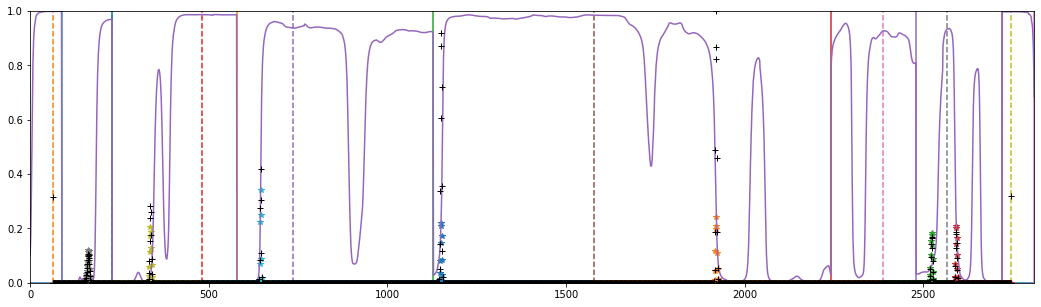

In [29]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18, 5))

ymax = 1

plt.plot([0, item[1][idx].item()], [0, 0])

for pivot in selected_frames_indices:
    plt.plot([pivot, pivot], [0, ymax], '--')
    
for pivot in boundary_frames_dict[cur_vidid + ".txt"]:
    plt.plot([pivot, pivot], [0, ymax])
    
all_prob = []
for i, segment in enumerate(prob_each_segment):
    segment = segment.cpu().numpy()
    print(f"Min prob {i} = {np.min(segment).item()}")
    xs = np.arange(selected_frames_indices[i], 
                   selected_frames_indices[i+1])
    plt.plot(xs, segment, '*')

    
plt_arr = []
for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 
plt.plot(np.arange(item[1][idx].item()), plt_arr)


loss_prob = torch.softmax(cur_vid_feat.unsqueeze(0), dim=2)
es_loss, loss_arr = get_estimated_loss(loss_prob, torch.tensor([item_1[idx]]), [item[4][idx]])
loss_arr = -loss_arr[0].detach().cpu().numpy()
plt.plot(np.arange(selected_frames_indices[0] - 1, selected_frames_indices[-1] + 1), loss_arr/np.max(loss_arr), 'k+')

plt.ylim([0, ymax])
plt.xlim([0, item[1][idx].item()])

In [40]:
loss_prob = torch.softmax(cur_vid_feat.unsqueeze(0), dim=2)
print(loss_prob.shape)
es_loss, loss_arr = get_estimated_loss(loss_prob, torch.tensor([item_1[idx]]), [item[4][idx]], item_2[idx].unsqueeze(0))

torch.Size([1, 1895, 48])


In [43]:
loss_arr[0].shape

torch.Size([1387])

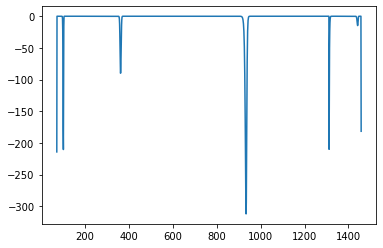

In [45]:
selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
plt.plot(np.arange(selected_frames[0] - 1, selected_frames[-1] + 1), loss_arr[0].detach().cpu().numpy())

In [44]:
es_loss

tensor(3.3987, device='cuda:0', dtype=torch.float64)

In [35]:
video_id_boundary_frames[cur_vidid], loaded_vidid_selected_frames[cur_vidid + ".txt"], item_1[idx]

([75, 345, 1305, 1415, 1440, 1519],
 [73, 282, 455, 1312, 1434, 1458],
 tensor(1520, device='cuda:0', dtype=torch.int32))

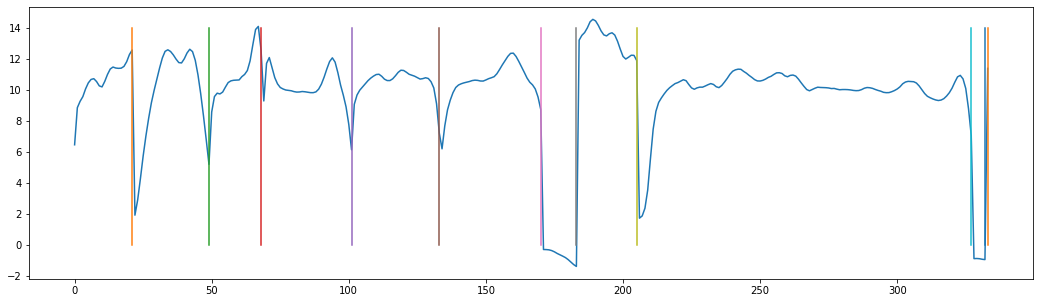

In [41]:
plt_arr = []
for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 

fig = plt.figure(figsize=(18, 5))
plt.plot(np.arange(item[1][idx].item()), plt_arr)

for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, 14])

torch.Size([334, 334])

In [37]:
cur_features_shortened = cur_vid_feat[:item[1][idx]]
cur_features_shortened[:, item[2][idx][:item[1][idx]]].shape
for

torch.Size([334, 334])

In [26]:
item[2][idx][video_id_boundary_frames[cur_vidid][1]-6:video_id_boundary_frames[cur_vidid][1]+9]

tensor([47, 47, 47, 47, 47, 47, 47,  4,  4,  4,  4,  4,  4,  4,  4])

In [25]:
video_id_boundary_frames[cur_vidid][0]-6,video_id_boundary_frames[cur_vidid][0]+9

6

In [27]:
cur_vid_feat[video_id_boundary_frames[cur_vidid][1]-7:video_id_boundary_frames[cur_vidid][1]+9][:,[47,4]]

tensor([[ 1.0794, 13.3350],
        [ 1.0831, 13.5102],
        [ 1.1767, 13.7662],
        [ 1.3750, 14.0177],
        [ 1.7298, 14.1727],
        [ 2.1706, 14.0367],
        [ 2.7338, 13.4563],
        [ 4.5600, 12.1745],
        [ 7.8450, 10.3246],
        [11.0151,  8.3563],
        [13.4775,  6.6546],
        [14.1836,  5.2898],
        [11.2142,  4.2791],
        [ 5.9829,  3.5694],
        [ 2.3440,  2.9389],
        [ 0.7406,  2.3515]], device='cuda:0')

In [19]:
def add_frames_and_get_classification_value(model_output, count_list, video_ids_list, labels_all, p_criterion):
    new_selected_frames = {}
#     new_selected_frames_probs_values = {}
#     new_selected_frames_labels = {}
    
    labels_arr = []
    probs_arr = []
    
    for i, video_id in enumerate(video_ids_list):
        current_boundary_frames = boundaries_dict[video_id]
        current_video_logits = model_output[i].T
        current_video_count = count_list[i]
        current_selected_frames = loaded_vidid_selected_frames[video_id]
        labels = labels_all[i]
        cur_seg_start = 0
        for seg_num, ele in enumerate(current_boundary_frames):
            cur_seg_end = ele + 1
            total_seg_len = cur_seg_end - cur_seg_start
            per_frames_far_from_boundary = int(0.3 * total_seg_len)
            new_frames_start = cur_seg_start + per_frames_far_from_boundary
            new_frames_end = cur_seg_end - per_frames_far_from_boundary
            
            frames_added = list(range(new_frames_start, new_frames_end))
            frames_added.append(current_selected_frames[seg_num])
            frames_added = list(set(frames_added))
            frames_added.sort()
            new_selected_frames[video_id] = frames_added

            
            labels_seg = torch.stack([labels[current_selected_frames[seg_num]]] * len(frames_added))
            frames_added = torch.tensor(np.array(frames_added), dtype=torch.long, device=current_video_logits.device)
            prob_seg = current_video_logits[frames_added, :]
            
            labels_arr.append(labels_seg)
            probs_arr.append(prob_seg)
            
            cur_seg_start = cur_seg_end
            
    labels_arr = torch.cat(labels_arr)
    probs_arr = torch.cat(probs_arr)
    loss = p_criterion(probs_arr, labels_arr)
    return loss

In [22]:
def find_mask_for_this_class(video_len, weakly_labels_video, old_index_label_pair_list, 
                             cur_ele_searched, cur_index_searched):
    searched_label_index = np.where(cur_ele_searched == np.array(weakly_labels_video))[0]
    if len(searched_label_index) <= 1:
        mask = torch.ones(video_len)
        return mask
    else:
        start = 0
        for i, index in enumerate(searched_label_index[:-1]):
            cur_index_frame_selected = old_index_label_pair_list[index][0]
            next_index = searched_label_index[i + 1]
            next_index_frame_selected = old_index_label_pair_list[next_index][0]
            
            mid_select = (cur_index_frame_selected + next_index_frame_selected) // 2
            
            if index == cur_index_searched:
                mask = torch.zeros(video_len)
                mask[start: mid_select + 1] = 1
                return mask
            
            start = mid_select
        if searched_label_index[-1] == cur_index_searched:
            mask = torch.zeros(video_len)
            mask[start: video_len] = 1
            return mask
        else:
            import pdb
            pdb.set_trace()
            return "Error 1"
    return "Error"

In [23]:
# [2, 2, 2, 2, 3, 3, 4, 4, 3, 3, 2, 2, 2, 2]
find_mask_for_this_class(12, [2, 3, 4, 3,  2], [3, 5, 7, 8, 10], 4, 2)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])